In [1]:
# Environment setup; succesful loading here should mean all dependencies correctly installed #
import numpy as np
import scanpy as sc
import anndata as anndata
from scipy import  stats
import seaborn as sbn
import matplotlib.pyplot as plt

# Load in the dataset 

In [2]:
pbmc = sc.read_h5ad('pbmc.h5ad')
print(f'The number of cells are: {pbmc.shape[0]}')
print(f'The number of genes are: {pbmc.shape[1]}') 

The number of cells are: 22475
The number of genes are: 32738


# Check coverage

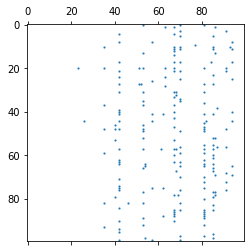

In [3]:
plt.spy(pbmc.X[:100, :100], markersize=1)

# QC Metrics 

In [4]:
#inplace saves all of the metrics to pbmc.obs
sc.pp.calculate_qc_metrics(pbmc, inplace=True)

In [5]:
pbmc.obs[0:5]

,cell-types,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACATACACCCAA-1,CD8+ Cytotoxic T,498,6.212606,1216.0,7.104144,44.572368,61.266447,75.493421,100.000000
AAACATACTTCTAC-1,CD8+ Cytotoxic T,925,6.830874,2683.0,7.895063,39.619829,55.348490,68.281774,84.159523
AAACATTGCTTCGC-1,CD8+ Cytotoxic T,554,6.318968,1310.0,7.178545,43.358779,58.931298,72.977099,95.877863
AAACCGTGCGATAC-1,CD8+ Cytotoxic T,687,6.533789,1854.0,7.525640,44.983819,60.302050,72.761597,89.913700
AAACCGTGTCACCC-1,CD8+ Cytotoxic T,471,6.156979,1274.0,7.150702,49.450549,65.227630,78.728414,100.000000


#### Plot the distribution before QC 

c:\Python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution before QC')]

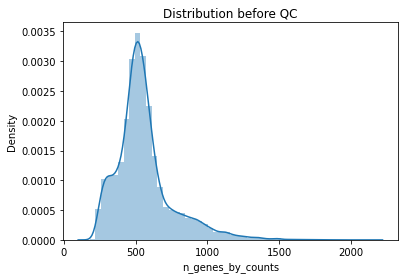

In [6]:
sbn.distplot(pbmc.obs['n_genes_by_counts']).set(title='Distribution before QC')

#### Identify cell types

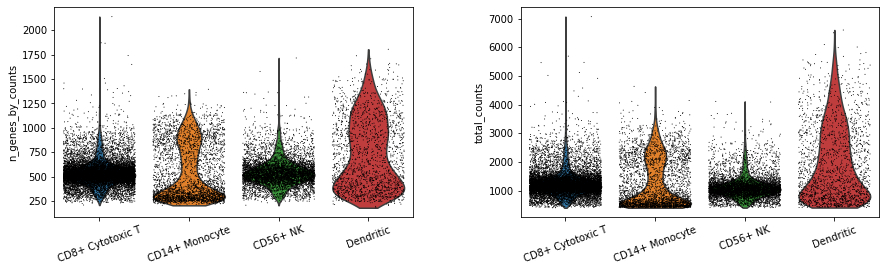

In [7]:
sc.pl.violin(pbmc, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'cell-types', rotation= 20)

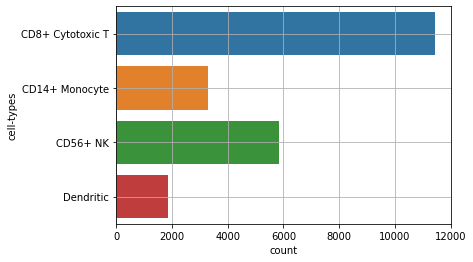

In [8]:
p =sbn.countplot(data=pbmc.obs, y='cell-types')
plt.grid()
plt.show()

#### Gene coverage as read counts increase

This plot gives us an indication of how we'll we're sampling genes
clearly the number of genes is underrepresented but the data is 
beggining to platau as total read counts increases which is a good sign

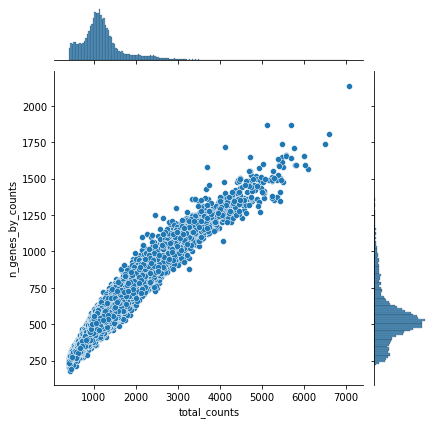

In [9]:
sbn.jointplot(data=pbmc.obs, x='total_counts', y='n_genes_by_counts')

#### Removing cells with too many or too few genes

Using a metric like Median absolute deviation we can remove outliers
that are expressing too many or too few genes per cell 

In [10]:
total_genes_per_cell = pbmc.obs['n_genes_by_counts']

median = np.median(total_genes_per_cell)


abs_deviation = abs(total_genes_per_cell - median)

MAD = np.median(abs_deviation)

lower_bound = median - MAD*3
upper_bound = median + MAD*3

outliers = len([x for x in total_genes_per_cell \
                if x < lower_bound or x > upper_bound])

print('Original number of cells: ' + str(len(total_genes_per_cell)))
print('Median #genes : ' + str(median))
print('MAD: ' + str(MAD))
print('Upper bound: ' + str(upper_bound))
print('Lower bound: ' + str(lower_bound))
print('Number of outliers: ' + str(outliers))

Original number of cells: 22475
Median #genes : 524.0
MAD: 86.0
Upper bound: 782.0
Lower bound: 266.0
Number of outliers: 3277


In [11]:
#Filter out these outliers with scanpy

sc.pp.filter_cells(pbmc, max_genes = upper_bound)
sc.pp.filter_cells(pbmc, min_genes = lower_bound)

print(f'Number of cells after filtering: {pbmc.shape[0]}')

Number of cells after filtering: 19198


#### Remove genes that are not present in enough cells 

We don't want to inflate our data with genes that either don't express at all or aren't in at least 3 cells

In [12]:
print("Genes before filtering: ", pbmc.shape[1])

sc.pp.filter_genes(pbmc, min_cells=3)

print("Genes after filtering: ", pbmc.shape[1])

Genes before filtering:  32738
Genes after filtering:  14945


#### Visualise the changes 

c:\Python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution after QC')]

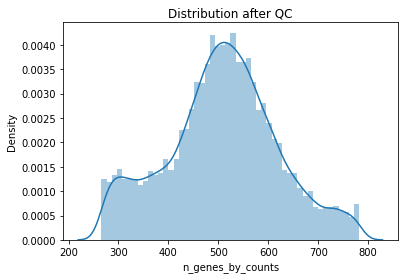

In [13]:
sbn.distplot(pbmc.obs['n_genes_by_counts']).set(title='Distribution after QC')


In [14]:
pbmc.layers['counts'] = pbmc.X.copy()

There are several ways to normalise scRNAseq - lets take a look at the differences based on their distributions


#### Perform normalisation using calculated library size 


In [15]:
og_data = pbmc.X.toarray()

#now we now how many reads each cell has in total 
reads_per_cell = og_data.sum(axis=1)

total_cells = pbmc.shape[0]

#total reads across all ~19000 cells 
total_library_size = sum(pbmc.obs['total_counts'])

#Calculate the size factor for library size normalisation 
size_factors = (reads_per_cell * total_cells) / total_library_size

norm_reads = np.apply_along_axis(np.divide, 0, og_data, size_factors)

#####THIS LINE IS WHAT MAKES OUR DATA FOLLOW THIS NORMALISATION
pbmc.X = norm_reads

#### Example of 10,000 counts per cell normalisation 

In [16]:
X = pbmc.layers['counts'].toarray()


reads_per_cells = X.sum(axis=1)
after = 1e4
scale_factors = reads_per_cells / after   # scale factor for each cell 

# Calculating 'counts-per-ten-thousand' normalisation between cells.
x_counts_norm = np.apply_along_axis(np.divide, 0, X, scale_factors)

reads_per_cells_norm = x_counts_norm.sum(axis=1)

#for constant library size
pbmc.layers['constant_ls'] = x_counts_norm

stats.describe(reads_per_cells_norm) # confirm that most cells have total reads ~1e4


DescribeResult(nobs=19198, minmax=(9999.913, 10000.092), mean=10000.0, variance=0.0005933718, skewness=-0.06664492934942245, kurtosis=-0.23289474552878398)

#### Normalisation by median 

In [17]:
X = pbmc.layers['counts'].toarray()

reads_per_cells = X.sum(axis=1)
median = np.median(reads_per_cell)
print(median)
scale_factors = reads_per_cells / median   # scale factor for each cell 

# Calculating 'counts-per-ten-thousand' normalisation between cells.
x_counts_norm = np.apply_along_axis(np.divide, 0, X, scale_factors)

reads_per_cells_norm = x_counts_norm.sum(axis=1)

#for constant library size
pbmc.layers['median_norm'] = x_counts_norm

stats.describe(reads_per_cells_norm) # confirm that most cells have total reads ~1e4


1105.0


DescribeResult(nobs=19198, minmax=(1104.9912, 1105.0095), mean=1105.0, variance=7.908801e-06, skewness=0.06783406436443329, kurtosis=-0.5836937236907622)

#### Now we can compare normalisation methods 


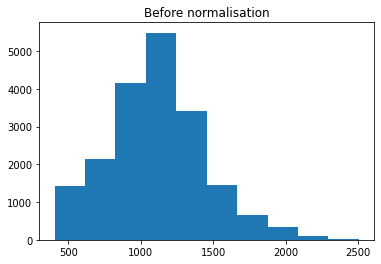

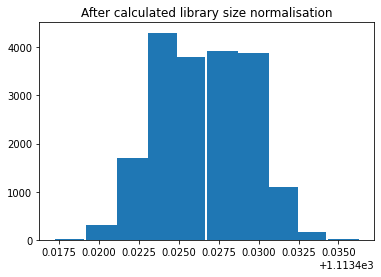

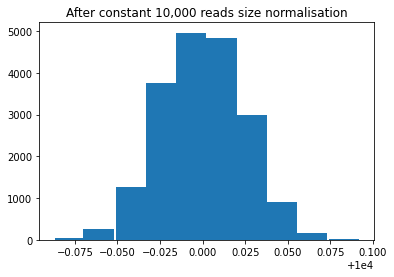

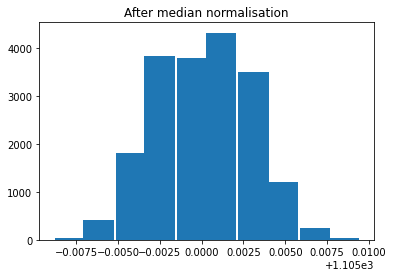

In [18]:
plt.hist(pbmc.layers['counts'].sum(axis=1))
plt.title('Before normalisation')
plt.show()

plt.hist(pbmc.X.sum(axis=1))
plt.title('After calculated library size normalisation')
plt.show()

plt.hist(pbmc.layers['constant_ls'].sum(axis=1))
plt.title('After constant 10,000 reads size normalisation')
plt.show()

plt.hist(pbmc.layers['median_norm'].sum(axis=1))
plt.title('After median normalisation')
plt.show()


#### Log-transformation 

We do this to reduce difference between genes that are expressing at very different levels so that we can do our feature selection. 

In [19]:
sc.pp.log1p(pbmc)

# Feature selection 

In [20]:
#all of the variables I selected are just the 
#default values from the docs

#Applys an annotation of variability so that we can plot it 
sc.pp.highly_variable_genes(pbmc, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [21]:
genes = pbmc.var['highly_variable']

variable_genes = genes[genes == True]

print(f'The number of variable genes are {len(variable_genes)}')

The number of variable genes are 903


#### Some cool plots showing the mean expression and variability of genes

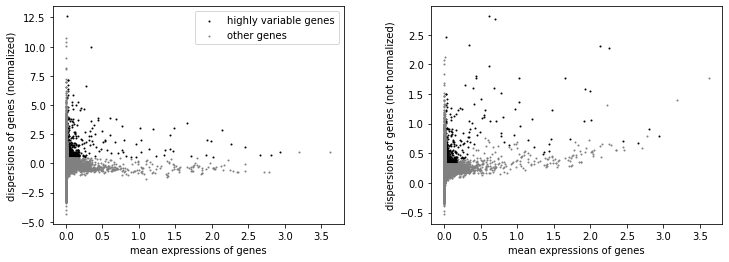

In [22]:
sc.pl.highly_variable_genes(pbmc)

#### Now we can subset our data set to only highly variable genes 

In [23]:
sc.pp.highly_variable_genes(pbmc, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)


In [24]:
print(f'The number of cells are: {pbmc.shape[0]}')
print(f'The number of genes are: {pbmc.shape[1]}') 

The number of cells are: 19198
The number of genes are: 903


# Visualisation 

#### PCA analysis 

In [25]:
sc.tl.pca(pbmc, svd_solver='arpack')

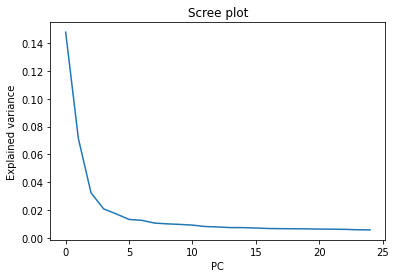

In [26]:
explained_variance = pbmc.uns['pca']['variance_ratio'][:25]

p = sbn.lineplot(data=explained_variance).set(title='Scree plot', \
                                             xlabel='PC', 
                                             ylabel='Explained variance')


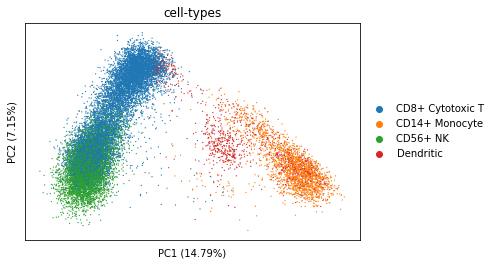

In [27]:
sc.pl.pca(pbmc, components='1,2', annotate_var_explained=True, color='cell-types')

#### UMAP representation 
Just experimenting with different cluster sizes here, can check the appropriate number of cluster neighbors 

#### 30 neighbors 

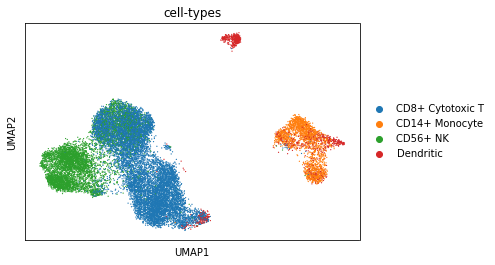

In [28]:
#neighbours is just a function that computes 
#pairwise distances between points for UMAP 
sc.pp.neighbors(pbmc, n_neighbors=30, n_pcs=40)

#now with our distances, we can create the UMAP plot
sc.tl.umap(pbmc)

sc.pl.umap(pbmc, color='cell-types')

#### 15 Neighbours

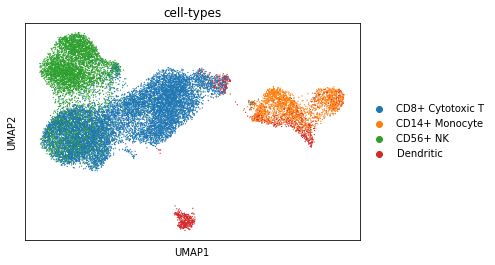

In [29]:
sc.pp.neighbors(pbmc, n_neighbors=15, n_pcs=13)

#now with our distances, we can create the UMAP plot
sc.tl.umap(pbmc)

sc.pl.umap(pbmc, color='cell-types')

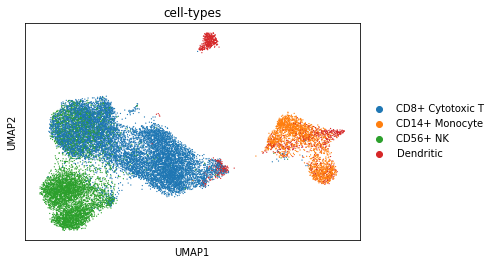

In [30]:
sc.pp.neighbors(pbmc, n_neighbors=15, n_pcs=20)

#now with our distances, we can create the UMAP plot
sc.tl.umap(pbmc)

sc.pl.umap(pbmc, color='cell-types')

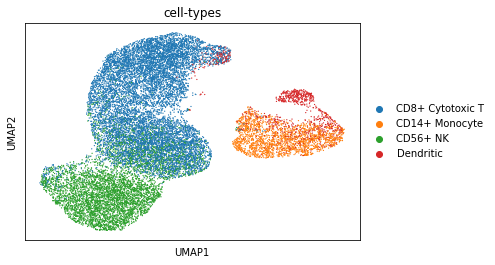

In [31]:
#now lets checkk the UMAP based on the elbow of the scree plot, which showed around PCAs = 4

sc.pp.neighbors(pbmc, n_neighbors=15, n_pcs=4)


sc.tl.umap(pbmc)

sc.pl.umap(pbmc, color='cell-types')

Top 10 most highly expressed genes based on normalised counts

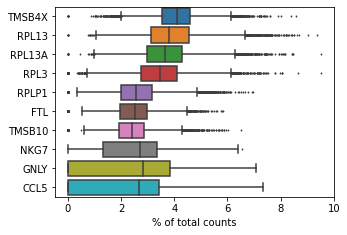

In [32]:
sc.pl.highest_expr_genes(pbmc, n_top=10, )

### Machine Learning

Using an autoencoder architecture with Stochastic gradient descent optimiser, KNN and random forest classification of the 4 cell types 

In [33]:
#ML imports
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [34]:
filt_df = pd.DataFrame(pbmc.X, index = pbmc.obs_names, columns = pbmc.var_names)
filt_df


,HES4,ISG15,TNFRSF18,TNFRSF4,ACAP3,MRPL20,RBP7,PGD,FBXO44,AGTRAP,...,MRPL39,USP16,C21orf119,IFNGR2,PDXK,PTTG1IP,S100B,MT-CO2,MT-CO3,MT-CYB
AAACATACACCCAA-1,0.0,0.000000,0.0,0.0,0.0,0.650055,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.650055,1.539570,1.320940
AAACATTGCTTCGC-1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.615155,0.000000,1.481554,0.993210,1.808234
AAACCGTGCGATAC-1,0.0,0.000000,0.0,0.0,0.0,0.470350,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.224427,2.104944,1.386986
AAACCGTGTCACCC-1,0.0,1.011345,0.0,0.0,0.0,0.000000,0.0,0.000000,0.628421,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.681431,1.287563,1.963264
AAACGCACGGGTGA-1,0.0,0.000000,0.0,0.0,0.0,0.821195,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.068092,0.821195,1.431038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTACTGG-8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.739465,1.682551,1.159905,1.159905
TTTCTACTGGGACA-8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.641143,0.641143,1.028654,0.641143
TTTGACTGAAGTAG-8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.538942,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.904127,1.519724,1.664902
TTTGACTGCCCAAA-8,0.0,0.000000,0.0,0.0,0.0,0.604478,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.918696,1.788717,1.788717


In [35]:
label_df = pd.DataFrame(pbmc.obs['cell-types'])
label_df

,cell-types
AAACATACACCCAA-1,CD8+ Cytotoxic T
AAACATTGCTTCGC-1,CD8+ Cytotoxic T
AAACCGTGCGATAC-1,CD8+ Cytotoxic T
AAACCGTGTCACCC-1,CD8+ Cytotoxic T
AAACGCACGGGTGA-1,Dendritic
...,...
TTTCGAACTACTGG-8,CD8+ Cytotoxic T
TTTCTACTGGGACA-8,CD8+ Cytotoxic T
TTTGACTGAAGTAG-8,CD8+ Cytotoxic T
TTTGACTGCCCAAA-8,CD8+ Cytotoxic T


### One Hot Encoding

In [36]:
labels = label_df['cell-types'].values
encoder = LabelEncoder() 
encoder.fit(labels)

encoded_Y = encoder.transform(labels)
encoded_Y

array([2, 2, 2, ..., 2, 2, 2])

In [37]:
#turns the encodings into vectors 
dummy_y = np_utils.to_categorical(encoded_Y)
# Let's say we want to split the data in 75 /12.5 /12.5 for train / valid / test dataset
X_train_n, X_remain_n, y_train_n, y_remain_n = train_test_split(filt_df, dummy_y, train_size=0.75, shuffle=True, random_state=7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_val_n, X_test_n, y_val_n, y_test_n = train_test_split(X_remain_n,y_remain_n, test_size=0.3, shuffle=True, random_state=7)
print(X_train_n.shape), print(y_train_n.shape)
print(X_remain_n.shape), print(y_remain_n.shape)
print(X_test_n.shape), print(y_test_n.shape)

(14398, 903)
(14398, 4)
(4800, 903)
(4800, 4)
(1440, 903)
(1440, 4)


(None, None)

#### Running the models

In [38]:
model = Sequential()

model.add(Dense(903, input_dim = 903, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
#tf.keras.metrics.Precision(),
#since classification binary_cross entropy was giving best result
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy', tf.keras.metrics.Recall()])

history = model.fit(X_train_n, y_train_n, validation_data = (X_val_n, y_val_n), epochs = 30, batch_size = 24)
model.summary()

Train on 14398 samples, validate on 3360 samples
Epoch 1/30
14398/14398 [==============================] - 6s 417us/step - loss: 0.3791 - accuracy: 0.8368 - recall: 0.5548 - val_loss: 0.2235 - val_accuracy: 0.9274 - val_recall: 0.6415
Epoch 2/30
14398/14398 [==============================] - 6s 400us/step - loss: 0.1668 - accuracy: 0.9371 - recall: 0.7114 - val_loss: 0.1517 - val_accuracy: 0.9339 - val_recall: 0.7541
Epoch 3/30
14398/14398 [==============================] - 6s 407us/step - loss: 0.1344 - accuracy: 0.9433 - recall: 0.7774 - val_loss: 0.1309 - val_accuracy: 0.9414 - val_recall: 0.7947
Epoch 4/30
14398/14398 [==============================] - 6s 396us/step - loss: 0.1195 - accuracy: 0.9495 - recall: 0.8071 - val_loss: 0.1192 - val_accuracy: 0.9506 - val_recall: 0.8186
Epoch 5/30
14398/14398 [==============================] - 6s 396us/step - loss: 0.1089 - accuracy: 0.9546 - recall: 0.8278 - val_loss: 0.1113 - val_accuracy: 0.9527 - val_recall: 0.8357
Epoch 6/30
14398/1439

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 903)               816312    
_________________________________________________________________
dense_2 (Dense)              (None, 600)               542400    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               60100     
_________________________________________________________________
dense_4 (Dense)              (None, 600)               60600     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2404      
Total params: 1,481,816
Trainable params: 1,481,816
Non-trainable params: 0
_________________________________________________________________


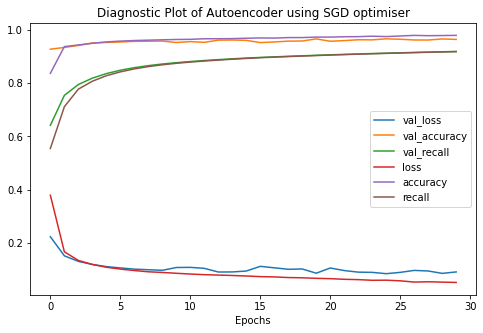

In [40]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Diagnostic Plot of Autoencoder using SGD optimiser")
plt.xlabel("Epochs")
plt.show()
#plt.savefig("neuralnetworktraining.png")

In [41]:
scores = model.evaluate(X_test_n, y_test_n, batch_size=32)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

check = model.evaluate(X_test_n,y_test_n, batch_size=20)
print(model.metrics_names)
print(check)

1440/1440 [==============================] - 0s 76us/step

accuracy: 96.37%
1440/1440 [==============================] - 0s 94us/step
['loss', 'accuracy', 'recall']
[0.09280837373161274, 0.9637152552604675, 0.9188153743743896]


Random Forest classification - Bagging ensemble

In [61]:
from sklearn.ensemble import RandomForestClassifier
#20 estimators
r_forest =RandomForestClassifier(n_estimators=20)
r_fit = r_forest.fit(X_train_n,y_train_n)

y_pred_rf =r_fit.predict(X_test_n)

In [43]:

print("Accuracy:",metrics.accuracy_score(y_test_n, y_pred_rf))

print("Precision:",metrics.precision_score(y_test_n, y_pred_rf, average='weighted'))

print("Recall:",metrics.recall_score(y_test_n, y_pred_rf, average='weighted'))

Accuracy: 0.8833333333333333
Precision: 0.9203578650434823
Recall: 0.8833333333333333


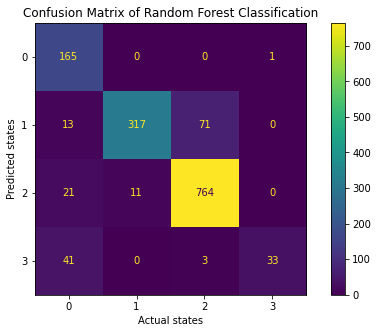

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1,1,figsize=(9,5))

ConfusionMatrixDisplay(confusion_matrix(y_test_n.argmax(axis=1), y_pred_rf.argmax(axis=1),labels=[0,1,2,3]),
                       display_labels=[0,1,2,3]).plot(values_format=".0f",ax=ax)

ax.set_title('Confusion Matrix of Random Forest Classification')
plt.ylabel('Predicted states')
plt.xlabel('Actual states')
plt.savefig("confusionmatrixRF.png")
plt.show()

Where 

0 - are CD8 T+

1 - are CD14

2 - are CD56

3 - natural killer 



#### Hyperparameter tuning and cross validation - RF

In [67]:
#Lets also check with some hyperparameter tuning methods to further decide if we can improve our models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
### lets check RF first - see params
r_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 21,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [64]:
# Hyperparameter Tuning
forest_params = [{'max_depth': list(range(1, 10)), 'n_estimators': list(range(1,10)), 'max_leaf_nodes': list(range(2,10))}]

#use CV = 5 
clf = RandomizedSearchCV(r_forest, forest_params, cv = 5, scoring='accuracy')
clf.fit(X_train_n, y_train_n)
best_params = clf.best_params_
print('Best parameters:', best_params)

Best parameters: {'n_estimators': 4, 'max_leaf_nodes': 9, 'max_depth': 8}


In [68]:
from sklearn.metrics import accuracy_score
# Fit and Evaluate on Testing Set using best params
r_forest.set_params(**best_params)
r_forest.fit(X_train_n, y_train_n)
y_pred = r_forest.predict(X_test_n)
print(classification_report(y_pred, y_test_n))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       175
           1       0.66      0.96      0.79       276
           2       0.97      0.85      0.91       909
           3       0.18      1.00      0.31        14

   micro avg       0.83      0.87      0.85      1374
   macro avg       0.66      0.90      0.70      1374
weighted avg       0.88      0.87      0.86      1374
 samples avg       0.83      0.83      0.83      1374



c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So with CV and hyperparameter tuning the accuracy is about the same

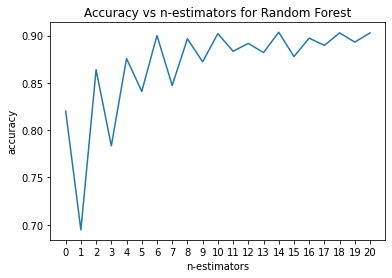

In [66]:
import random 

accs_rf = []
k = list(range(21))
for n in range(21):
    r_forest = RandomForestClassifier(n_estimators=n+1, random_state = random.seed(1234))
    r_forest.fit(X_train_n, y_train_n)
    accs_rf.append(r_forest.score(X_test_n, y_test_n))
plt.plot(k, accs_rf)
plt.xlabel("n-estimators")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 21, 1))
plt.title("Accuracy vs n-estimators for Random Forest")
plt.show()

Interestingly this causes a "sawtooth" like accuracy curve based on the increased n-estimators. 
Possible reasons may be attributed is that random forest is stochasticity and also potential overfitting.
 However, it's worth mentioning too maybe that the number of trees in a random forest doesn't really need to be tuned in some cases, at least not in the same way as other hyperparameters. 
 Adding more trees just stabilizes the results (since you're averaging more samples from a distribution of trees); you want enough trees to get stable results, and adding more won't hurt except for computational resources.

k-NN


In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train_n,y_train_n)
ypred=knn_clf.predict(X_test_n) 

In [49]:
print("Accuracy:",metrics.accuracy_score(y_test_n, ypred))

print("Precision:",metrics.precision_score(y_test_n, ypred, average='weighted'))

print("Recall:",metrics.recall_score(y_test_n, ypred, average='weighted'))

Accuracy: 0.8625
Precision: 0.8694161874405049
Recall: 0.8625


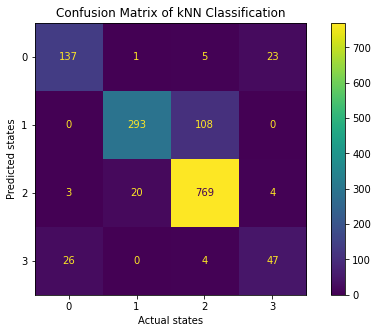

In [50]:
fig, ax = plt.subplots(1,1,figsize=(9,5))

ConfusionMatrixDisplay(confusion_matrix(y_test_n.argmax(axis=1), ypred.argmax(axis=1),labels=[0,1,2,3]),
                       display_labels=[0,1,2,3]).plot(values_format=".0f",ax=ax)

ax.set_title('Confusion Matrix of kNN Classification')
plt.ylabel('Predicted states')
plt.xlabel('Actual states')
plt.savefig("confusionmatrixkNN.png")
plt.show()

In this notebook, we analysed 10x genomics scRNAseq PBMCs. Using a couple of classification machine learning techniques our models performed reasonably well to classify the 4 different types of cells in our PBMC dataset. Overall I learnt about the pipeline analysis for scRNAseq :)